In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt

In [2]:
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    

In [3]:
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def reversible_michaelismenten(x, y, vm, keq, kmx, kmy):
    return (vm*(x - (y/keq)))/(x + kmx*(1+(y/kmy)))

def hilleqn(x, vm, n, km):
    return (vm*x**n)/(km**n + x**n)

def michaelismenten_substrateactivation(x, vm, km, a, ka):
    vm_eff = vm * (1+ (a*x)/(ka + x))
    return (vm_eff*x)/(km  + x)

def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)
    
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

In [53]:
# Set architecture equations
def glucaric_acid(t, y, ydot, params):
    ## Establish constants
    lam = 2.7778E-05
    v_pts = 0.1656
    vm_pgi = 0.8751
    keq_pgi = 0.3
    km_pgi_g6p = 0.28
    km_pgi_f6p = 0.147
    vm_zwf = 0.0853
    km_zwf_g6p = 0.1
    vm_pfk = 2.615
    km_pfk_f6p = 0.16
    n_pfk = 3
    vm_ino1 = 0.2616
    km_ino1_g6p = 1.18
    vm_t_mi = 0.045
    km_t_mi = 15
    vm_miox = 0.2201
    km_miox_mi = 24.7
    a_miox = 5.4222
    ka_miox_mi = 20
    
    A, W = params

    v_zwf = michaelismenten(y[0], vm_zwf, km_zwf_g6p)
    v_pgi = reversible_michaelismenten(y[0], y[1], vm_pgi, keq_pgi, km_pgi_g6p, km_pgi_f6p)
    v_ino1 = y[3]*michaelismenten(y[0], vm_ino1, km_ino1_g6p)
    ydot[0] = v_pts - v_zwf - v_pgi - v_ino1 - lam*y[0]

    v_pfk = hilleqn(y[1], vm_pfk, n_pfk, km_pfk_f6p)
    ydot[1] = v_pgi + 0.5 * v_zwf - v_pfk - lam*y[1]

    #MI
    v_tm = michaelismenten(y[2], vm_t_mi, km_t_mi)
    v_miox = y[4] *michaelismenten_substrateactivation(y[2], vm_miox, km_miox_mi, a_miox, ka_miox_mi)
    ydot[2] = v_ino1 - v_tm - v_miox - lam*y[2]

    #Ino1
    u_ino1_mi = np.sum(A[0]*np.array([activation(y[2], W[0][2], W[0][1], W[0][0]), repression(y[2], W[0][2], W[0][1], W[0][0]), W[0][2]]))
    ydot[3] = u_ino1_mi - lam*y[3]
    
    #MIOX
    u_miox_mi = np.sum(A[1]*np.array([activation(y[2], W[1][2], W[1][1], W[1][0]), repression(y[2], W[1][2], W[1][1], W[1][0]), W[1][2]]))
    ydot[4] = u_miox_mi - lam*y[4]

    #J1, J2
    ydot[5] = (v_pts - v_miox)**2
    ydot[6] = u_ino1_mi + u_miox_mi

In [54]:
losses = []
params = []
circuits = []

def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.1, 0.1, 0., 0., 0., 0. , 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)

    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    

In [55]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=1)
space_eval(space, best)

100%|██████████| 1/1 [00:00<00:00, 30.72trial/s, best loss: 0.0]



[CVODE ERROR]  CVode
  At t = 260.514, mxstep steps taken before reaching tout.



(((0, 0, 1), (0, 0, 1)),
 ((2.0, 0.17737164419177687, 1.1563557866091134),
  (2.0, 7.299396940742156, 1.599880027645609)))

In [9]:
def glucaric_acid(t, y, ydot, params):

    lam = 2.7778E-05
    v_pts = 0.1656
    vm_pgi = 0.8751
    keq_pgi = 0.3
    km_pgi_g6p = 0.28
    km_pgi_f6p = 0.147
    vm_zwf = 0.0853
    km_zwf_g6p = 0.1
    vm_pfk = 2.615
    km_pfk_f6p = 0.16
    n_pfk = 3
    vm_ino1 = 0.2616
    km_ino1_g6p = 1.18
    vm_t_mi = 0.045
    km_t_mi = 15
    vm_miox = 0.2201
    km_miox_mi = 24.7
    a_miox = 5.4222
    ka_miox_mi = 20


    g6p, f6p, mi, ino1, miox, j1, j2 = y

    A, W = params 

    n_ino1, theta_ino1, k_ino1 = W[0]
    n_miox, theta_miox, k_miox = W[1]

    v_pgi = reversible_michaelismenten(g6p, f6p, vm_pgi, keq_pgi, km_pgi_g6p, km_pgi_f6p)
    v_zwf = michaelismenten(g6p, vm_zwf, km_zwf_g6p)
    v_pfk = hilleqn(f6p, vm_pfk, n_pfk, km_pfk_f6p)
    v_ino1 = ino1 * michaelismenten(g6p, vm_ino1, km_ino1_g6p)
    v_tm = michaelismenten(mi, vm_t_mi, km_t_mi)
    v_miox = miox * michaelismenten_substrateactivation(mi, vm_miox, km_miox_mi, a_miox, ka_miox_mi)

    u_ino1_mi = np.sum(A[0]*np.array([activation(mi, k_ino1, theta_ino1, n_ino1), repression(mi, k_ino1, theta_ino1, n_ino1), k_ino1]))
    u_miox_mi = np.sum(A[1]*np.array([activation(mi, k_miox, theta_miox, n_miox), repression(mi, k_miox, theta_miox, n_miox), k_miox]))

    ydot[0] = v_pts - v_zwf - v_pgi - lam*g6p
    ydot[1] = v_pgi + 0.5*v_zwf - v_pfk - lam*f6p
    ydot[2] = v_ino1 - v_tm - v_miox - lam*mi
    ydot[3] = u_ino1_mi  - lam*ino1
    ydot[4] = u_miox_mi - lam*miox
    ydot[5] = (v_pts - v_miox)**2
    ydot[6] = u_ino1_mi + u_miox_mi

13711.611097469004 0.061633502383544286 0.13773244599852547


Text(0, 0.5, 'Concentrations')

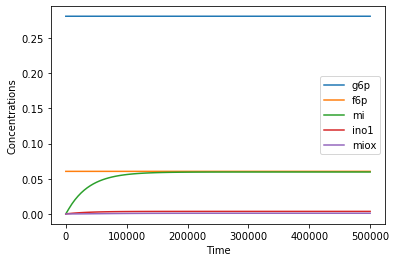

In [10]:
t = np.linspace(0, 5E5, 100) 
y0 = np.array([0.281, 0.0605, 0., 0., 0., 0., 0.]) #g6p, f6p, mi, ino1, miox

architecture = ((0, 1, 0), (1, 0, 0))
param_values = ((2.0, 8.46E-01, 1E-7),
  (2.0, 0.1, 1E-7))
  
extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
ode_solver = ode('cvode', glucaric_acid, **extra_options)
solution = ode_solver.solve(t, y0)

j1, j2 = solution.values.y[-1, -2:]
j1, j2, loss = loss_biological(j1, j2)
print(j1, j2, loss)

plt.plot(t, solution.values.y[:, 0], label='g6p')
plt.plot(t, solution.values.y[:, 1], label='f6p')
plt.plot(t, solution.values.y[:, 2], label='mi')
plt.plot(t, solution.values.y[:, 3], label='ino1')
plt.plot(t, solution.values.y[:, 4], label='miox')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')

In [22]:
losses = []
params = []
circuits = []

def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)

    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    

In [25]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)
space_eval(space, best)

 38%|███▊      | 38/100 [00:01<00:02, 23.31trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1191.18, mxstep steps taken before reaching tout.



100%|██████████| 100/100 [00:03<00:00, 25.02trial/s, best loss: 0.0]


(((0, 1, 0), (1, 0, 0)),
 ((2.0, 7.644160153319337, 1.0599890214536676),
  (2.0, 3.552639749552137, 2.565381810571637)))

In [ ]:
#Tune alpha values? 
#CVODE error is resulting in best loss going to zero. Add check for CVODE solution correct and investigate bad cases